# Iris Flower - Batch Prediction

In this notebook we will,
1. Load the batch inference data that arrived in the last 24 hours.
2. Predict the first Iris Flower found n the batch.
3. Write the output png of the Iris flower predicted, to be displayed in GitHub pages.

In [1]:
import pandas as pd
import hopsworks
import joblib
import os
from dotenv import load_dotenv

load_dotenv()

api_key = str(os.getenv('HOPSWORKS_API_KEY'))

In [2]:
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()

2025-02-19 00:59:09,743 INFO: Initializing external client


2025-02-19 00:59:09,744 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-02-19 00:59:10,551 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1212597


In [3]:
mr = project.get_model_registry()
model = mr.get_model("iris", version=3)
model_dir = model.download()
model = joblib.load(model_dir + "/iris_model.pkl")
label_encoder = joblib.load(model_dir + "/label_encoder.pkl")

Now we will do some **Batch Inference**

We will read all the input features that have arrived in the last 24 hours, and score them.

In [4]:
feature_view = fs.get_feature_view("iris", version=1)

In [5]:
import datetime
from PIL import Image

batch_data = feature_view.get_batch_data()

y_pred = model.predict(batch_data)
y_pred

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


array([0, 0, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1,
       1, 0, 2, 0, 0, 1, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 1,
       2, 1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2,
       1, 0, 1, 1, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 2, 0, 1, 0, 0, 2,
       2, 0, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 2, 0, 2, 2,
       1, 2], dtype=int32)

In [6]:
batch_data

,sepal_length,sepal_width,petal_length,petal_width
0,5.367117,4.434446,1.374910,0.497858
1,4.900000,3.600000,1.400000,0.100000
2,5.700000,2.500000,5.000000,2.000000
3,5.700000,3.000000,4.200000,1.200000
4,6.700000,3.300000,5.700000,2.100000
...,...,...,...,...
151,5.132883,2.365554,1.825090,0.502142
152,5.980721,2.311288,6.153158,2.250375
153,4.630351,2.743195,5.200417,1.737836
154,6.695723,3.242433,3.152837,1.426165


Batch prediction output is the last entry in the batch - it is output as a file 'latest_iris.png'

In [7]:
flower = y_pred[y_pred.size - 1]
flower_img = "../assets/" + label_encoder.classes_[flower] + ".png"
img = Image.open(flower_img)
img.save("../assets/latest_iris.png")

In [8]:
iris_fg = fs.get_feature_group("iris", version=1)
df = iris_fg.read()
df.tail()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.39s) 


,sepal_length,sepal_width,petal_length,petal_width,variety
151,5.132883,2.365554,1.825090,0.502142,Setosa
152,5.980721,2.311288,6.153158,2.250375,Virginica
153,4.630351,2.743195,5.200417,1.737836,Versicolor
154,6.695723,3.242433,3.152837,1.426165,Versicolor
155,7.115449,2.296980,6.320534,2.280652,Virginica


In [9]:
label = df.iloc[-1]['variety']
label

'Virginica'

In [10]:
label_flower = "../assets/" + label + ".png"
img = Image.open(label_flower)
img.save("../assets/actual_iris.png")

In [11]:
import pandas as pd

monitor_fg = fs.get_or_create_feature_group(
    name="iris_predictions",
    version=1,
    primary_key=["datetime"],
    description="Iris flower Prediction/Outcome Monitoring"
)

In [12]:
from datetime import datetime
now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

data = {
    'prediction': [label_encoder.classes_[flower]],
    'label': [label],
    'datetime': [now],
}
monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df)

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:00 | Remaining Time: 00:00

Launching job: iris_predictions_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1212597/jobs/named/iris_predictions_1_offline_fg_materialization/executions


(Job('iris_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [13]:
history_df = monitor_fg.read()
history_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.42s) 


,prediction,label,datetime
0,Setosa,Setosa,"02/14/2025, 19:11:48"
1,Setosa,Setosa,"02/14/2025, 19:12:49"
2,Setosa,Setosa,"02/14/2025, 19:16:53"
3,Virginica,Versicolor,"02/14/2025, 19:18:35"
4,Virginica,Versicolor,"02/14/2025, 19:21:27"
5,Virginica,Virginica,"02/14/2025, 19:28:25"
6,Virginica,Virginica,"02/15/2025, 06:35:15"
7,Virginica,Virginica,"02/15/2025, 06:42:17"
8,Virginica,Virginica,"02/16/2025, 01:04:01"
9,Virginica,Virginica,"02/17/2025, 01:01:27"


In [14]:
import dataframe_image as dfi

df_recent = history_df.tail(5)

dfi.export(df_recent, '../assets/df_recent.png',
           table_conversion='matplotlib')

2025-02-19 00:59:26,813 INFO: Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: Can not load face (unknown file format; error code 0x2)


2025-02-19 00:59:27,541 INFO: generated new fontManager


In [15]:
from sklearn.metrics import confusion_matrix

predictions = history_df[['prediction']]
labels = history_df[['label']]

results = confusion_matrix(labels, predictions)
print(results)

[[3 0 0]
 [0 0 2]
 [0 0 6]]


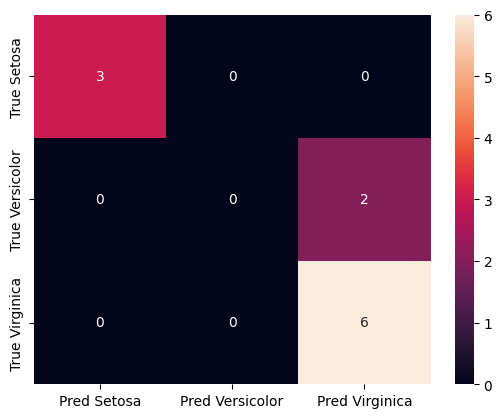

In [16]:
from matplotlib import pyplot
import seaborn as sns

# Only create the confusion matrix when our iris_predictions feature group has examples of all 3 iris flowers
if results.shape == (3, 3):

    df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                         ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

    cm = sns.heatmap(df_cm, annot=True)

    fig = cm.get_figure()
    fig.savefig("../assets/confusion_matrix.png")
    df_cm
else:
    print("Run the batch inference pipeline more times until you get 3 different iris flowers")